In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from dataset import prepare_datasets

def visualize_single_sample(image, mask, index):
    # Create a new figure for this sample
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    # Convert image to numpy and transpose from CHW to HWC
    img_np = image.numpy().transpose(1, 2, 0)
    # Normalize values to [0, 1] if needed
    if img_np.max() > 1.0:
        img_np = img_np / 255.0
    
    # Convert mask to numpy and squeeze
    mask_np = mask.numpy().squeeze()
    
    # Create masked image
    masked_img = img_np.copy()
    masked_img = masked_img * np.stack([mask_np, mask_np, mask_np], axis=2)
    
    # Display original image
    axes[0].imshow(img_np)
    axes[0].set_title(f"Original Image {index+1}")
    axes[0].axis('off')
    
    # Display mask
    axes[1].imshow(mask_np, cmap='gray')
    axes[1].set_title(f"Mask {index+1}")
    axes[1].axis('off')
    
    # # Display masked image
    # axes[2].imshow(masked_img)
    # axes[2].set_title(f"Masked Image {index+1}")
    # axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"sample_{index+1}.png")
    plt.show()

def visualize_dataset(dataset, num_samples=5):

    for i in range(num_samples):
        if i >= len(dataset):
            break
            
        image, mask = dataset[i]
        visualize_single_sample(image, mask, i)

In [2]:
DATA_DIR = './Datasets/'
TRAIN_INPUT_IMAGES_FILE  = 'defacto_train_input_images.pt'
TRAIN_TARGET_IMAGES_FILE = 'defacto_train_target_images.pt'
VALID_INPUT_IMAGES_FILE  = 'defacto_valid_input_images.pt'
VALID_TARGET_IMAGES_FILE = 'defacto_valid_target_images.pt'


train_dataset, valid_dataset, train_size, valid_size = prepare_datasets(
    restart_mode=False,
    data_dir=DATA_DIR,
    train_input_file=TRAIN_INPUT_IMAGES_FILE,
    train_target_file=TRAIN_TARGET_IMAGES_FILE,
    valid_input_file=VALID_INPUT_IMAGES_FILE,
    valid_target_file=VALID_TARGET_IMAGES_FILE
)


# Usage example
# visualize_dataset(train_dataset, num_samples=5)

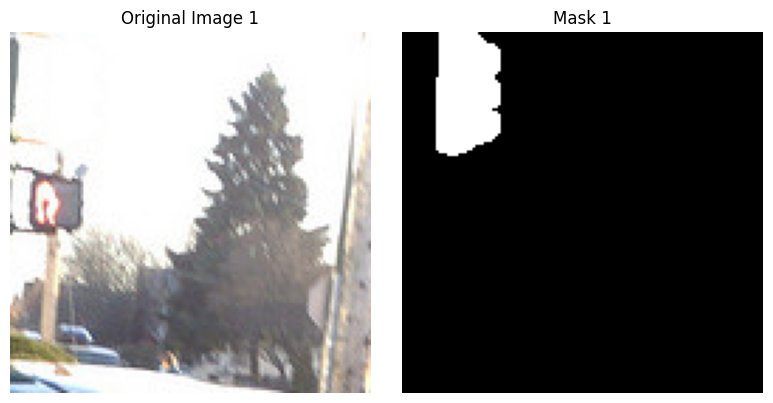

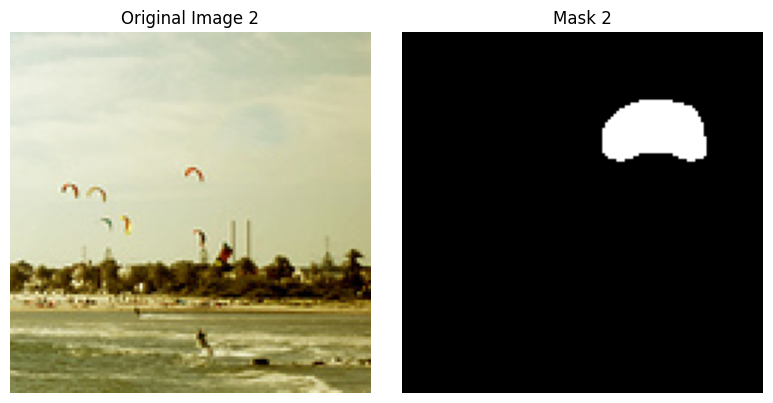

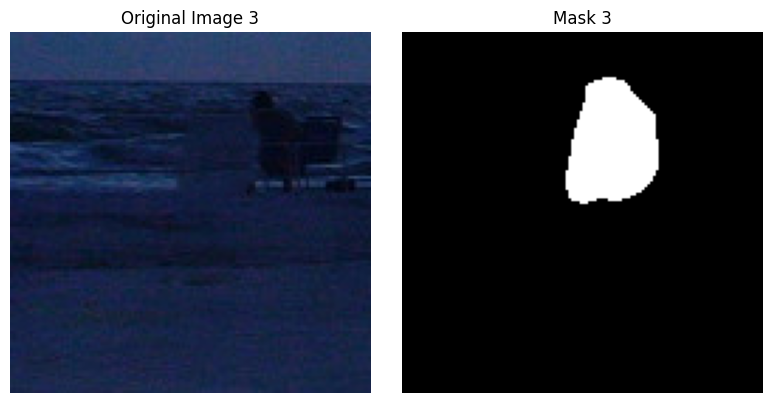

In [8]:
# Usage example
visualize_dataset(train_dataset, num_samples=3)

In [4]:
from dataset import create_dataloaders

BATCH_SIZE = 10  # Define your batch size

train_dataloader, valid_dataloader = create_dataloaders(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    batch_size=BATCH_SIZE
)

In [5]:
import segmentation_models_pytorch as smp

# パラメーター
ENCODER = "efficientnet-b4"
ENCODER_WEIGHTS = "imagenet"
ACTIVATION = "sigmoid"
CLASS_NUM = 1 # segmentationの正解ラベル数

# モデル定義
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=CLASS_NUM, 
    activation=ACTIVATION,
)

In [6]:
from segmentation_models_pytorch import utils

DEVICE = "cuda"

loss = utils.losses.DiceLoss()
metrics = [utils.metrics.IoU(threshold=0.5)]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])

train_epoch = utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [7]:
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_dataloader)
    valid_logs = valid_epoch.run(valid_dataloader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 20/20 [00:01<00:00, 14.09it/s, dice_loss - 0.3115, iou_score - 0.5393]
Model saved!

Epoch: 1
valid: 100%|██████████| 20/20 [00:01<00:00, 13.97it/s, dice_loss - 0.2565, iou_score - 0.5995]
Model saved!

Epoch: 2
valid: 100%|██████████| 20/20 [00:01<00:00, 14.05it/s, dice_loss - 0.2309, iou_score - 0.6332]
Model saved!

Epoch: 3
valid: 100%|██████████| 20/20 [00:01<00:00, 13.75it/s, dice_loss - 0.2172, iou_score - 0.65]  
Model saved!

Epoch: 4
valid: 100%|██████████| 20/20 [00:01<00:00, 14.10it/s, dice_loss - 0.2034, iou_score - 0.6673]
Model saved!

Epoch: 5
valid: 100%|██████████| 20/20 [00:01<00:00, 13.39it/s, dice_loss - 0.2032, iou_score - 0.6701]
Model saved!

Epoch: 6
valid: 100%|██████████| 20/20 [00:01<00:00, 13.95it/s, dice_loss - 0.2054, iou_score - 0.6686]

Epoch: 7
valid: 100%|██████████| 20/20 [00:01<00:00, 13.99it/s, dice_loss - 0.1941, iou_score - 0.6821]
Model saved!

Epoch: 8
valid: 100%|██████████| 20/20 [00:01<00:00, 13.70it/s, dice

KeyboardInterrupt: 